Our project is about the best neighborhood for budget friendly activities. We've chosen to measure this three datasets. Mine is about public arts. I'll start by setting up the environment. This means importing the geographic data of the neighborhoods of Pittsburgh. 

My plan is to show which neighborhoods have the most public art, and I can narrow down this analysis by showing what types of art are in each neighborhood. 

In [23]:
import geopandas as gpd
import pandas as pd

neighborhood_data = gpd.read_file('Neighborhoods_.shp')
neighborhood_data.head(3)

,OBJECTID,fid_blockg,statefp10,countyfp10,tractce10,blkgrpce10,geoid10,namelsad10,mtfcc10,funcstat10,...,created_us,created_da,last_edite,last_edi_1,temp,pghdb_sde_,GlobalID,Shape__Are,Shape__Len,geometry
0,1,233,42,003,140500,3,420031405003,Block Group 3,G5030,S,...,SDE,2020-08-14,SDE,2020-08-14,None,7968760.0,a642a6b6-a2a9-48d5-acf2-3e2ce87d4bc0,8.153647e+06,14047.065024,"POLYGON ((-79.90560 40.45522, -79.90553 40.455..."
1,2,203,42,003,140100,3,420031401003,Block Group 3,G5030,S,...,SDE,2020-08-14,SDE,2020-08-14,None,34078712.0,20d4605b-258e-441a-a57e-a28fdabb6d30,3.407739e+07,30347.886823,"POLYGON ((-79.91309 40.43804, -79.91321 40.438..."
2,3,86,42,003,101700,2,420031017002,Block Group 2,G5030,S,...,SDE,2020-08-14,SDE,2020-08-14,None,12751163.0,bf4065e7-c29c-48bd-b529-e7fd99077238,1.275116e+07,14577.441571,"POLYGON ((-79.93457 40.47217, -79.93455 40.472..."


Now I will load in the data from public arts, stored in the file arts_data.csv.

In [24]:
arts_data = gpd.read_file('arts_data.csv')

arts_data.head(3)

,id,name,title,artist_name,art_type,park,image,neighborhood,council_district,ward,tract,public_works_division,pli_division,police_zone,fire_zone,latitude,longitude,geometry
0,812728309,1001,Oakwood Road Monument,n/a,,,,Oakwood,2,28,42003562800,5,28,6,1-19,40.42919154,-80.06622538,None
1,188255168,1002,Rooster Waiting For The Streetcar,James Simon,Modern and Contemporary Art,,,Elliott,2,20,42003562600,5,20,6,1-17,40.44292638,-80.03971116,None
2,2032091917,129,Middle East Memorial Plaque,n/a,War Memorials,,,Central Business District,6,1,42003020100,6,1,2,1-4,40.438092,-79.996852,None


So basically it appears that there is no geometry to link to, but we do have coordinates. These coordinates will be useful for getting a preliminary plot. Before we can plot, however, we should clean up these dataframes so that they have only the information we need.

In [46]:
neighborhoods = pd.DataFrame(columns=["Neighborhood","Geometry","Total count"])
neighborhoods['Neighborhood'] = neighborhood_data['hood']
neighborhoods['Geometry'] = neighborhood_data['geometry']
neighborhoods['Total count'] = 0

Here we can do the work of finding a count of public art in each neighborhood.

In [47]:
for row in neighborhoods.iterrows():
    hood_name = row[1][0] # hood name in neighborhoods df
    hood_num = row[0]
    for artwork in arts_data.iterrows():
        art_hood = artwork[1][7] # hood name in arts_data df
        if art_hood == hood_name:
            # match, we can increment total count at that neighborhood
            neighborhoods.at[hood_num,'Total count'] += 1

In [49]:
neighborhoods.head()

,Neighborhood,Geometry,Total count
0,Point Breeze North,"POLYGON ((-79.90560 40.45522, -79.90553 40.455...",0
1,Squirrel Hill North,"POLYGON ((-79.91309 40.43804, -79.91321 40.438...",2
2,Garfield,"POLYGON ((-79.93457 40.47217, -79.93455 40.472...",2
3,Bedford Dwellings,"POLYGON ((-79.96601 40.45520, -79.96596 40.454...",0
4,Knoxville,"POLYGON ((-79.98845 40.41851, -79.98821 40.418...",1


So already this is progressing, and we can see neighborhoods with both nonzero and zero counts. Let's now sort this and only plot nonzero neighborhoods as to make the plot pretty.

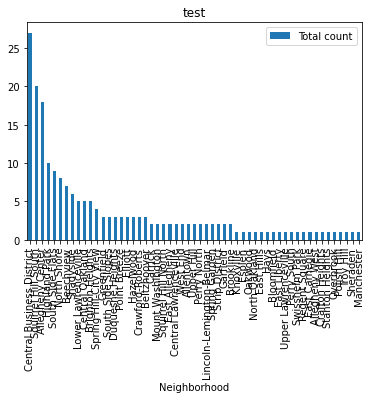

In [54]:
neighborhoods_clean = neighborhoods.sort_values('Total count', ascending=False)

neighborhoods_clean = neighborhoods_clean[neighborhoods_clean['Total count'] != 0]
# removing nonzero values

plt = neighborhoods_clean.plot(kind='bar', x='Neighborhood', y='Total count', title='test')

This plot is a bit rough; the text is small. Let's plot only the top 15. 

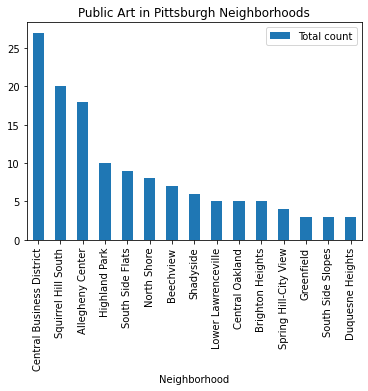

In [59]:
plt = neighborhoods_clean.iloc[:15].plot(kind='bar', 
                                         x='Neighborhood', 
                                         y='Total count', 
                                         title='Public Art in Pittsburgh Neighborhoods')

Our visualizations are taking shape, and we can see the top 15 neighborhoods for public art in Pittsburgh! Notice that many neighborhoods don't appear. I originally tried plotting 20, but there was a flat line at the end of neighborhoods with the same amount of art. I chose 15 to emphasize the head of the distribution. Next what I'd like to do is make a count, per neighborhood, of the types of art they have. Some examples of these types are Modern and Contemporary Art and War Memorials. To start, let's just see how much of each type Pittsburgh has in general.

In [74]:
# set(arts_data['art_type']) gives us a list of all art types, so we can make columns for this in a new DF
art_genres = pd.DataFrame(columns=["Neighborhood",
                                   "Geometry",
                                   "War Memorials",
                                   "Individual and Historic Monuments",
                                   "Non-City Owned",
                                   "Modern and Contemporary Art",
                                   "Historic Art"])

art_genres['Neighborhood'] = neighborhood_data['hood']
art_genres['Geometry'] = neighborhood_data['geometry']
art_genres['War Memorials'] = 0
art_genres['Individual and Historic Monuments'] = 0
art_genres['Non-City Owned'] = 0
art_genres['Modern and Contemporary Art'] = 0
art_genres['Historic Art'] = 0

for artwork in arts_data.iterrows():
    genre = artwork[1][4] # art_type
    art_hood = artwork[1][7]
    for hood in art_genres.iterrows():
        hood_real = hood[1][0]
        hood_pos = hood[0]
        if hood_real == art_hood:
            if genre == 'War Memorials':
                # increment art_genres table for neighborhood count of war memorials
                art_genres.at[hood_pos,'War Memorials'] += 1
            if genre == 'Individual and Historic Monuments':
                art_genres.at[hood_pos,'Individual and Historic Monuments'] += 1
            if genre == 'Non-City Owned':
                art_genres.at[hood_pos,'Non-City Owned'] += 1
            if genre == 'Modern and Contemporary Art':
                art_genres.at[hood_pos,'Modern and Contemporary Art'] += 1
            if genre == 'Historic Art':
                art_genres.at[hood_pos,'Historic Art'] += 1

art_genres.head()

,Neighborhood,Geometry,War Memorials,Individual and Historic Monuments,Non-City Owned,Modern and Contemporary Art,Historic Art
0,Point Breeze North,"POLYGON ((-79.90560 40.45522, -79.90553 40.455...",0,0,0,0,0
1,Squirrel Hill North,"POLYGON ((-79.91309 40.43804, -79.91321 40.438...",0,0,0,0,0
2,Garfield,"POLYGON ((-79.93457 40.47217, -79.93455 40.472...",0,0,1,1,0
3,Bedford Dwellings,"POLYGON ((-79.96601 40.45520, -79.96596 40.454...",0,0,0,0,0
4,Knoxville,"POLYGON ((-79.98845 40.41851, -79.98821 40.418...",0,0,1,0,0


This looks nice, and we can make it even better by doing a join on these two DFs I've created to essentially add a total column to the art_genres DF. That will give us the following code.

In [75]:
total_arts = pd.DataFrame(columns=["Neighborhood",
                                   "Geometry",
                                   "Total art count",
                                   "War Memorials",
                                   "Individual and Historic Monuments",
                                   "Non-City Owned",
                                   "Modern and Contemporary Art",
                                   "Historic Art"])

total_arts["Neighborhood"] = neighborhoods['Neighborhood']
total_arts['Geometry'] = neighborhoods['Geometry']
total_arts['Total art count'] = neighborhoods['Total count']
total_arts['War Memorials'] = art_genres['War Memorials'] 
total_arts['Individual and Historic Monuments'] = art_genres['Individual and Historic Monuments']
total_arts['Non-City Owned'] = art_genres['Non-City Owned']
total_arts['Modern and Contemporary Art'] = art_genres['Modern and Contemporary Art']
total_arts['Historic Art'] = art_genres['Historic Art']

total_arts.head()

,Neighborhood,Geometry,Total art count,War Memorials,Individual and Historic Monuments,Non-City Owned,Modern and Contemporary Art,Historic Art
0,Point Breeze North,"POLYGON ((-79.90560 40.45522, -79.90553 40.455...",0,0,0,0,0,0
1,Squirrel Hill North,"POLYGON ((-79.91309 40.43804, -79.91321 40.438...",2,0,0,0,0,0
2,Garfield,"POLYGON ((-79.93457 40.47217, -79.93455 40.472...",2,0,0,1,1,0
3,Bedford Dwellings,"POLYGON ((-79.96601 40.45520, -79.96596 40.454...",0,0,0,0,0,0
4,Knoxville,"POLYGON ((-79.98845 40.41851, -79.98821 40.418...",1,0,0,1,0,0


Let's clean this up before making some plots about it. 

In [78]:
total_clean = total_arts.sort_values('Total art count', ascending=False)

# removing nonzero values
total_clean = total_clean[total_clean['Total art count'] != 0]

And now we can produce a plot showing the amount of arts per type per neighborhood. Let's try with a multi bar graph.

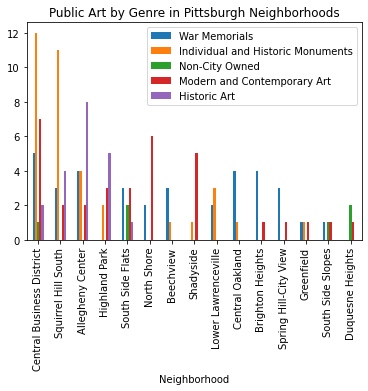

In [83]:
plt = total_clean.iloc[:15].plot(kind='bar', 
                                         x='Neighborhood', 
                                         y=['War Memorials',
                                            'Individual and Historic Monuments', 
                                            'Non-City Owned', 
                                            'Modern and Contemporary Art', 
                                            'Historic Art'], 
                                         title='Public Art by Genre in Pittsburgh Neighborhoods')

Someone interested in historic art might find this next plot useful.

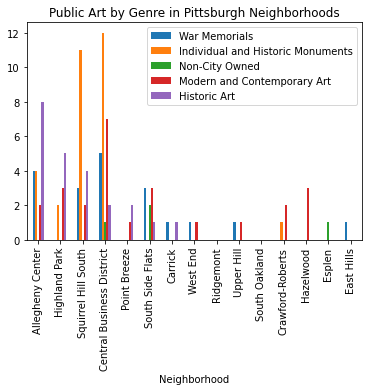

In [85]:
total_clean = total_arts.sort_values('Historic Art', ascending=False)

plt = total_clean.iloc[:15].plot(kind='bar', 
                                         x='Neighborhood', 
                                         y=['War Memorials',
                                            'Individual and Historic Monuments', 
                                            'Non-City Owned', 
                                            'Modern and Contemporary Art', 
                                            'Historic Art'], 
                                         title='Public Art by Genre in Pittsburgh Neighborhoods')

So here we see the best place for Historic Art is Allegheney Center, followed by Highland Park. Let's finish with a geographic plot of the most "artful" neighborhood, to see where exactly each one lies. 

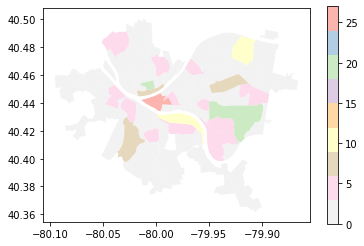

In [104]:
neighborhood_data['Total art count'] = total_arts['Total art count']
neighborhood_data.plot(column='Total art count', legend=True, cmap='Pastel1_r')

Hence, we find that Downtown has the most public art for someone looking to enjoy the arts without spending any money. 